# Workshop week 6: Time Series Forecasing with ARIMA and LSTM

Set seed for reproducibility

In [10]:
# caveat: setting seed this way isn't threadsafe.
import random
import numpy as np
random.seed(0)
np.random.seed(0)

## 1. Forecasting with ARIMA

Below is the code we used in lecture week 5.
Please review this code, make sure you are able to explain what it is doing.
Please run the code.
If you remember what (p,d,q) parameters were used in lecture to get lowest MAPE, please use them here. If not look up the lecture or ask your neighbour.

MAPE:  0.5787297232471471
RMSE:  16180.52752442133


/Users/nic/anaconda3/envs/CS7306/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


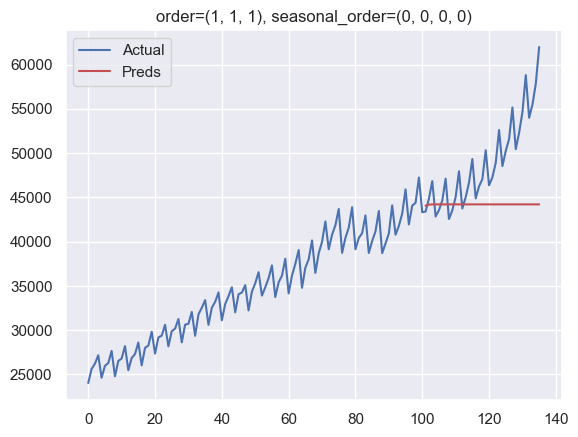

In [2]:
# !pip uninstall sklearn
# !pip uninstall scikit-learn -y
# !pip install sklearn


from statsmodels.datasets import get_rdataset
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import root_mean_squared_error as rmse
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Get data
uk = get_rdataset('UKNonDurables', 'AER')
uk = uk.data
uk_pre1980 = uk[uk.time <= 1980]
print(uk_pre1980)
# Make ARIMA model
# order: p : autoregressive order. d : difference order. q : moving average order
# trend: trend inputs are 'c' (constant), 't' (linear trend in time), 
#    'ct' (both), 'ctt' (both with trend squared) or an interable defining a polynomial, 
#  e.g., [1, 1, 0, 1] is `a + b*t + ct**3`
#   BUT: if you include trend, the d must be 0 (d will eliminate trend, so does not make sense)
order = (1, 1, 1)
# Without a seasonal component
seasonal_order = (0, 0, 0, 0)
arima = ARIMA(uk_pre1980.value, 
            order=order, 
            seasonal_order=seasonal_order, 
            trend='n')
res = arima.fit()
# Plot
all_elements = len(uk) - len(uk_pre1980)
MAPE = mape(uk_pre1980.value[:all_elements], res.forecast(steps=all_elements))
rmse = rmse(uk_pre1980.value[:all_elements], res.forecast(steps=all_elements))
print("MAPE: ", MAPE)
print("RMSE: ", rmse)

plt.plot(uk.value, 'b', label='Actual')
plt.plot(res.forecast(steps=all_elements), 'r', label='Preds')
plt.title(f'order={order}, seasonal_order={seasonal_order}')
plt.legend()
plt.show()

### Task 1: Adapt this code to use with Apple Stock Prediction data

Download AAPL.csv from the workshop page and adapt the above code to forecast the stock.

Divide the code into training 60%, validation 20% and test 20%

Use training/validation to find the best ARIMA parameters, then train the model on train + validation and test on the test part.

You can also use RMSE as a metric (commented out in the code)

Answer the following questions:

1. Are the optimal parameters different than in case of UKNonDurables dataset?
2. If so, what they tell you about the difference in the datasets?
3. Are the validation results different from the test? If so, why?

#### Download and split the data

In [2]:
# Download AAPL.csv from the workshop page and adapt the above code to forecast the stock.
import pandas as pd
df = pd.read_csv(r'./AAPL.csv')
df['Date'] = pd.to_datetime(df['Date'],format="%d/%m/%Y")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2264 non-null   datetime64[ns]
 1   Open       2264 non-null   float64       
 2   High       2264 non-null   float64       
 3   Low        2264 non-null   float64       
 4   Close      2264 non-null   float64       
 5   Adj Close  2264 non-null   float64       
 6   Volume     2264 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 123.9 KB


In [3]:
# Divide the code into training 60%, validation 20% and test 20%
# For AAPL, let the target be Close Price
train = round(df.shape[0] * 0.6)
val = train + round(df.shape[0] * 0.2)
test = val + round(df.shape[0] * 0.2)

# since it is time series let these indices be out boundaries
# e.g. [0 -> 1358],[1359, 1811], [1812, 2264]
df_train = df.iloc[0:train,:]
df_val = df.iloc[train:val,:] 
df_test = df.iloc[val:test,:]

X_train, y_train = df_train['Date'], df_train['Close']
X_val, y_val = df_val['Date'], df_val['Close']
X_test, y_test = df_test['Date'], df_test['Close']

#### Find the best parameters using Training and Validation

### Task 2: Time series analysis

Here is the snippets of code from the lecture and from this web page:

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

#### Finding the differencing order

In [11]:
# d is the differencing level
# Augmented Dickey Fuller test (ADF) is used to test for stationarity of series.
# null hypothesis of the ADF test is that the time series is non-stationary
# P Value > 0.05, series needs (more) differentiating. 
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.dropna()) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1])


TypeError: float() argument must be a string or a real number, not 'Timestamp'

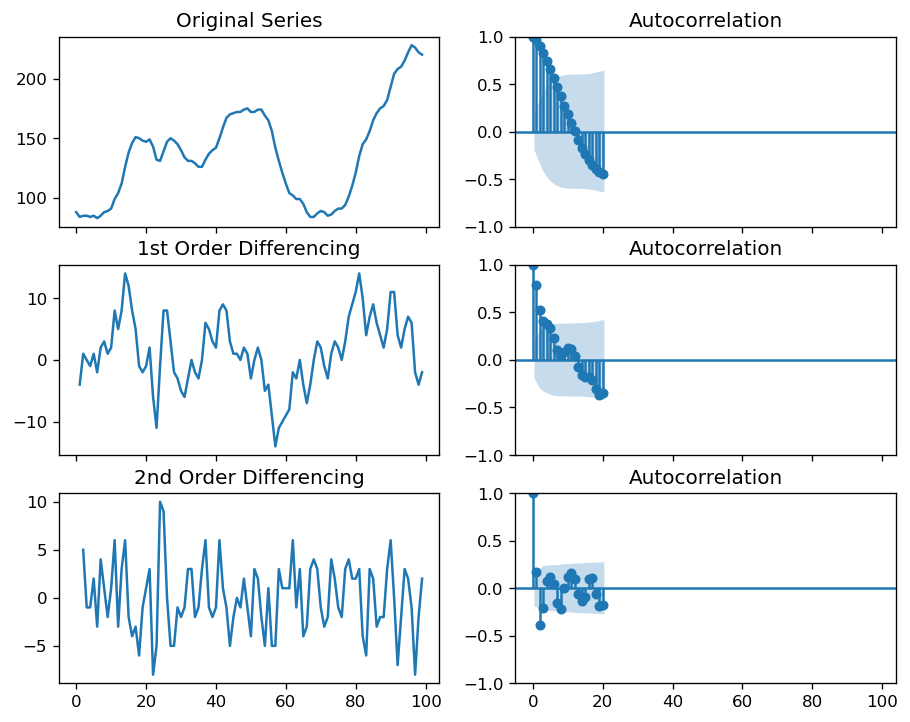

In [14]:
### time series differentiation to find the right d value
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.values); axes[0, 0].set_title('Original Series')
plot_acf(df.values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna().values, ax=axes[2, 1])

plt.show()

#### Find the AR parameter p

This is the code from the above web page:

In [ ]:
# PACF plot of 1st differenced series
# AR -> PACF
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

#### Find MA parameter q

The code:

In [ ]:
# MA -> hehe
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/austa.csv')

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

### Task 2: Use the above code for AAPL.csv

Adapt the above code to find the optimal ARIMA parameters.

Test the model again with these parameters. 

1. Are the results better than before? Discuss in the class.

## 2. Forecasting with LSTM

Please download the Notebook TimeSeriesForecasting_LSTMs.ipynb

This code contains a number of methods to forecast using LSTM.

**Univariate forecasting in moving window**
1. Given k last observations of y time series (univariate), predict single next value
2. Given k last observations of y time series (univariate), predict multiple values

**Multivariate forecasting**

3. Given all past observations of time series and all variables, x together with y, predict single future value y in the data.
4. Given all past observations of time series and all variables, x together with y, predict multiple future values y in the data.

#### Task 3: Adapt the following code to predict univariate multiple values using LSTM

In [15]:
# This function creates the data we need for the above problem
# dataset: numpy ndarray
# start_index:
# end_index:
# history_size: k => take k values at a time
# target_size: 0 => next value in the time-series
# Output: data: (n,k) and labels (n,1)

## Each row x_train_uni, x_val_uni contains 20 consecutive values of Y, 
## each y_train_uni, y_val_uni has one next value 20+1
## x=1,20, y=21
## x=2,21, y=22

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


# use the above function to create the datasets.
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)





NameError: name 'uni_data' is not defined

In [ ]:
# TF Dataset preperation
BATCH_SIZE = 256 # bacth size in batch-SGD/variants
BUFFER_SIZE = 10000 # for shuffling the dataset

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()# defaule is repeated till number of time batch run
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

print(train_univariate)
print(val_univariate)


In [ ]:
# MODEL:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

# Why not GRUs?
# https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/3436/grus/8/module-8-neural-networks-computer-vision-and-deep-learning
# https://www.quora.com/Whats-the-difference-between-LSTM-and-GRU

In [ ]:
# Train and evaluate
STEPS_PER_EPOCH = 200
EPOCHS = 10

# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate, validation_steps=50)

In [ ]:
plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
plot.show()

### OPTIONAL Task 4: Adapt the following code to predict multivariate multiple values using LSTM

In [ ]:
# Features
features_considered = ['feature1', 'feature2', 'feature3']

features = df[features_considered]

# Standardize data

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std



In [ ]:
# Same as univariate_data above.
# data is: samples taken every 10 min.

# New params:
# step: instead of taking data for each 10min, you want to generate data once evrey 6 steps (60min)
#### so one sample per hour
# single_step: lables from single timestamp or multiple timesteps

## this code does the same as the above 
##  takes samples of data every step number
## it takes not just one y, but all x and historical T, therefore multivariate
#### y to predict is next y after train+step


def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step) # step used here.
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)

In [ ]:
# Generate data
past_history = 720 # 720*10 mins 
future_target = 72 # 72*10 mins
STEP = 6 # one obs every 6X10min = 60 min => 1 hr

# past history: 7200 mins => 120 hrs, sampling at ones sample evry hour, so 120 samples each 2 vars 
# future_target: 720 mins = > 12 hrs in the future, not next hour

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print(x_train_single.shape)
print(y_train_single.shape)

# print(x_train_single[0])
# print(y_train_single[0])


In [ ]:
#TF dataset

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

print(train_data_single)
print(val_data_single)

**configure and built LSTM model here, compile and fit, similar to the code for the univariate version**

**then plot the result by adapting this code**

In [ ]:
# plot time series and predicted values

plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
plot.show()


#### Task 5: Compare results of prediction from Task 3 and Task 4 (if completed) with Task 2 results.